# Molecular dynamics

So far, we have used ramannoodle to calculate Raman spectra from phonons. This approach works well for systems where atomic motion is sufficiently harmonic. In others, thermal motion of atoms is strongly anharmonic, meaning that the "wiggles" of the atoms are no longer well-described by phonons. 

To accurately calculate Raman spectra for these systems, we use molecular dynamics (MD). The tutorial will demonstrate how to calculate MD-based Raman spectra using ramannoodle. This notebook is available on available on [Github](https://github.com/wolearyc/ramannoodle/blob/main/docs/source/notebooks/molecular-dynamics.ipynb).  

First, some setup.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['lines.linewidth'] = 1.5

### Constructing the polarizability model

Our final goal is to calculate TiO2's Raman spectrum. We will construct an interpolation model as [we have done previously](basics.html).

In [2]:
import ramannoodle.io.vasp as vasp_io
from ramannoodle.polarizability.interpolation import InterpolationModel

data_dir = "../../../test/data/TiO2"
ref_structure = vasp_io.poscar.read_ref_structure(f"{data_dir}/POSCAR")

# We'll need the polarizability of the reference structure. 
_, ref_polarizability = vasp_io.outcar.read_positions_and_polarizability(
   f"{data_dir}/ref_eps_OUTCAR"
)
model = InterpolationModel(ref_structure, ref_polarizability)

# OUTCARS are polarizability calculation where atom 5 (Ti) 
# was displaced +0.1 and +0.2 angstrom in the x direction
model.add_dof_from_files(
    [f"{data_dir}/Ti5_0.1x_eps_OUTCAR", f"{data_dir}/Ti5_0.2x_eps_OUTCAR"],
    file_format = 'outcar', interpolation_order=2)

# atom 5 moving +0.1 and +0.2 angstroms in the z direction
model.add_dof_from_files([f"{data_dir}/Ti5_0.1z_eps_OUTCAR",
                          f"{data_dir}/Ti5_0.2z_eps_OUTCAR"],
                            file_format = 'outcar', interpolation_order=2)

# atom 43 moving in the z direction
model.add_dof_from_files([f"{data_dir}/O43_0.2z_eps_OUTCAR",
                          f"{data_dir}/O43_0.1z_eps_OUTCAR", 
                          f"{data_dir}/O43_m0.1z_eps_OUTCAR", 
                          f"{data_dir}/O43_m0.2z_eps_OUTCAR"], file_format= 'outcar', interpolation_order=2)

model.add_dof_from_files([f"{data_dir}/O43_0.1x_eps_OUTCAR",
                         f"{data_dir}/O43_0.2x_eps_OUTCAR"], 
                         file_format = 'outcar', interpolation_order=2)

model.add_dof_from_files([f"{data_dir}/O43_0.1y_eps_OUTCAR",
                          f"{data_dir}/O43_0.2y_eps_OUTCAR"],
                            file_format = 'outcar', interpolation_order=2)

# We should now have specified all 324 DOFs
model

InterpolationModel with 324/324 degrees of freedom specified.

Our interpolation model is fully specified! Now, we read in an MD trajectory. 

### Raman spectrum from high quality MD trajectory

In [3]:
from ramannoodle.dynamics.trajectory import Trajectory

# This trajectory is not publicly available. Sorry! 
# If you want to follow along in your # own notebook, scroll further.
trajectory = vasp_io.vasprun.read_trajectory(
    f"/Volumes/Untitled/md/TiO2/production.xml"
)

In [4]:
# Compute spectrum
spectrum = trajectory.get_raman_spectrum(model)

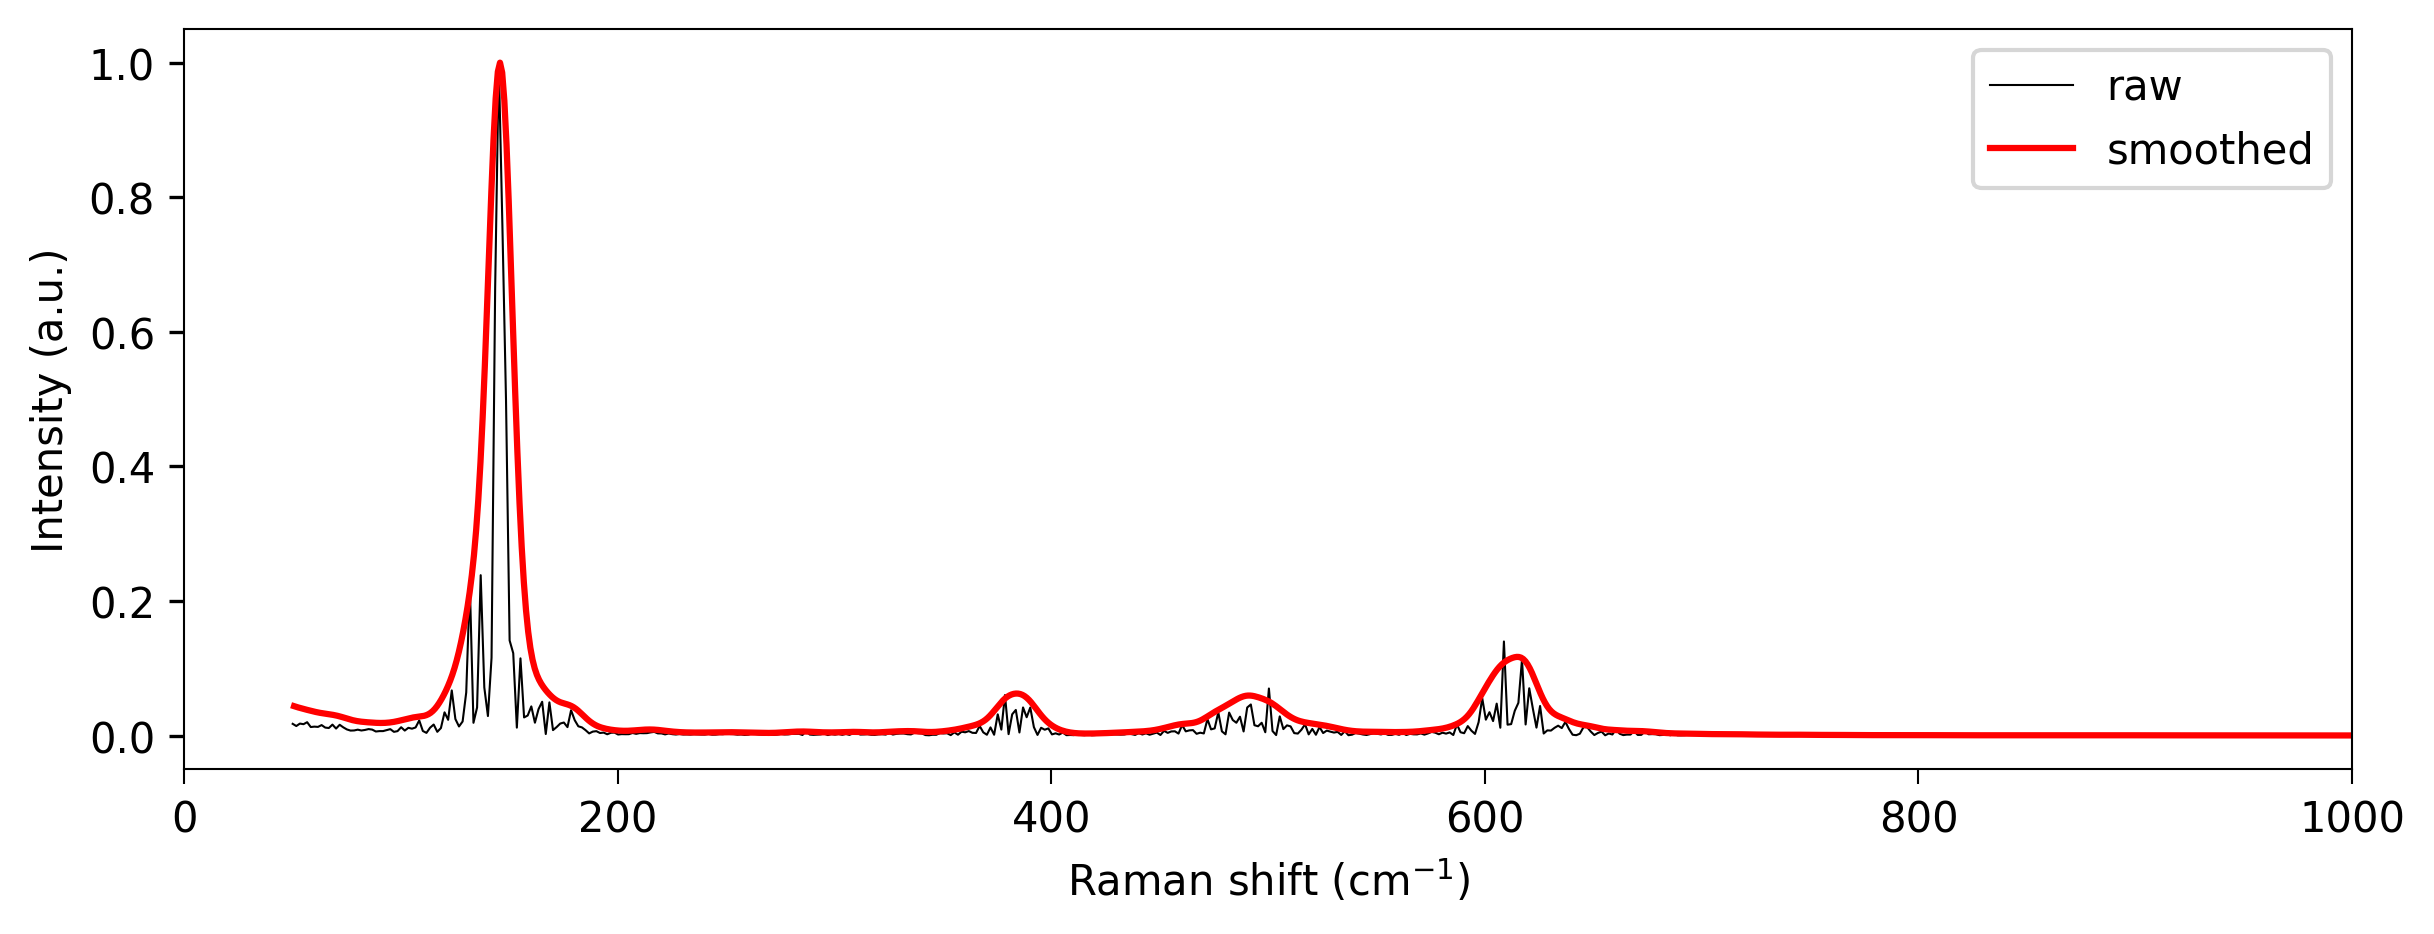

In [5]:
from ramannoodle.spectrum.spectrum_utils import convolve_spectrum

# Then plot
wavenumbers, total_intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)

fig = plt.figure(constrained_layout = True, figsize = (8, 3))
axis = fig.add_subplot(111)
lower_cutoff = 50 
axis.plot(
    wavenumbers[wavenumbers > lower_cutoff], 
    total_intensities[wavenumbers > lower_cutoff] / np.max(total_intensities[wavenumbers > lower_cutoff]), 
    label = "raw", color = 'black', linewidth = 0.5
)
wavenumbers, total_intensities = convolve_spectrum(wavenumbers, total_intensities)
axis.plot(
    wavenumbers[wavenumbers > lower_cutoff], 
    total_intensities[wavenumbers > lower_cutoff] / np.max(total_intensities[wavenumbers > lower_cutoff]), 
    label = "smoothed", color = "red"
)

axis.set_xlim((0,1000))
axis.legend()
axis.set_ylabel("Intensity (a.u.)")
l = axis.set_xlabel(r"Raman shift ($\mathregular{cm^{-1}}$)")

A few comments. First, MD-derived Raman spectra are somewhat noisy (black curve). We smooth out this noise using ``convolve_spectrum`` (red curve). Second, we do not plot the spectrum below 50 cm-1. This is because inclusion of the laser wavelength correction terms (``laser_correction = True``) leads to large intensities at low Raman shifts. 

### Raman spectrum from publicly available MD trajectory

Let's repeat the above steps using a TiO2 trajectory available in the [ramannoodle Github](https://github.com/wolearyc/ramannoodle).   

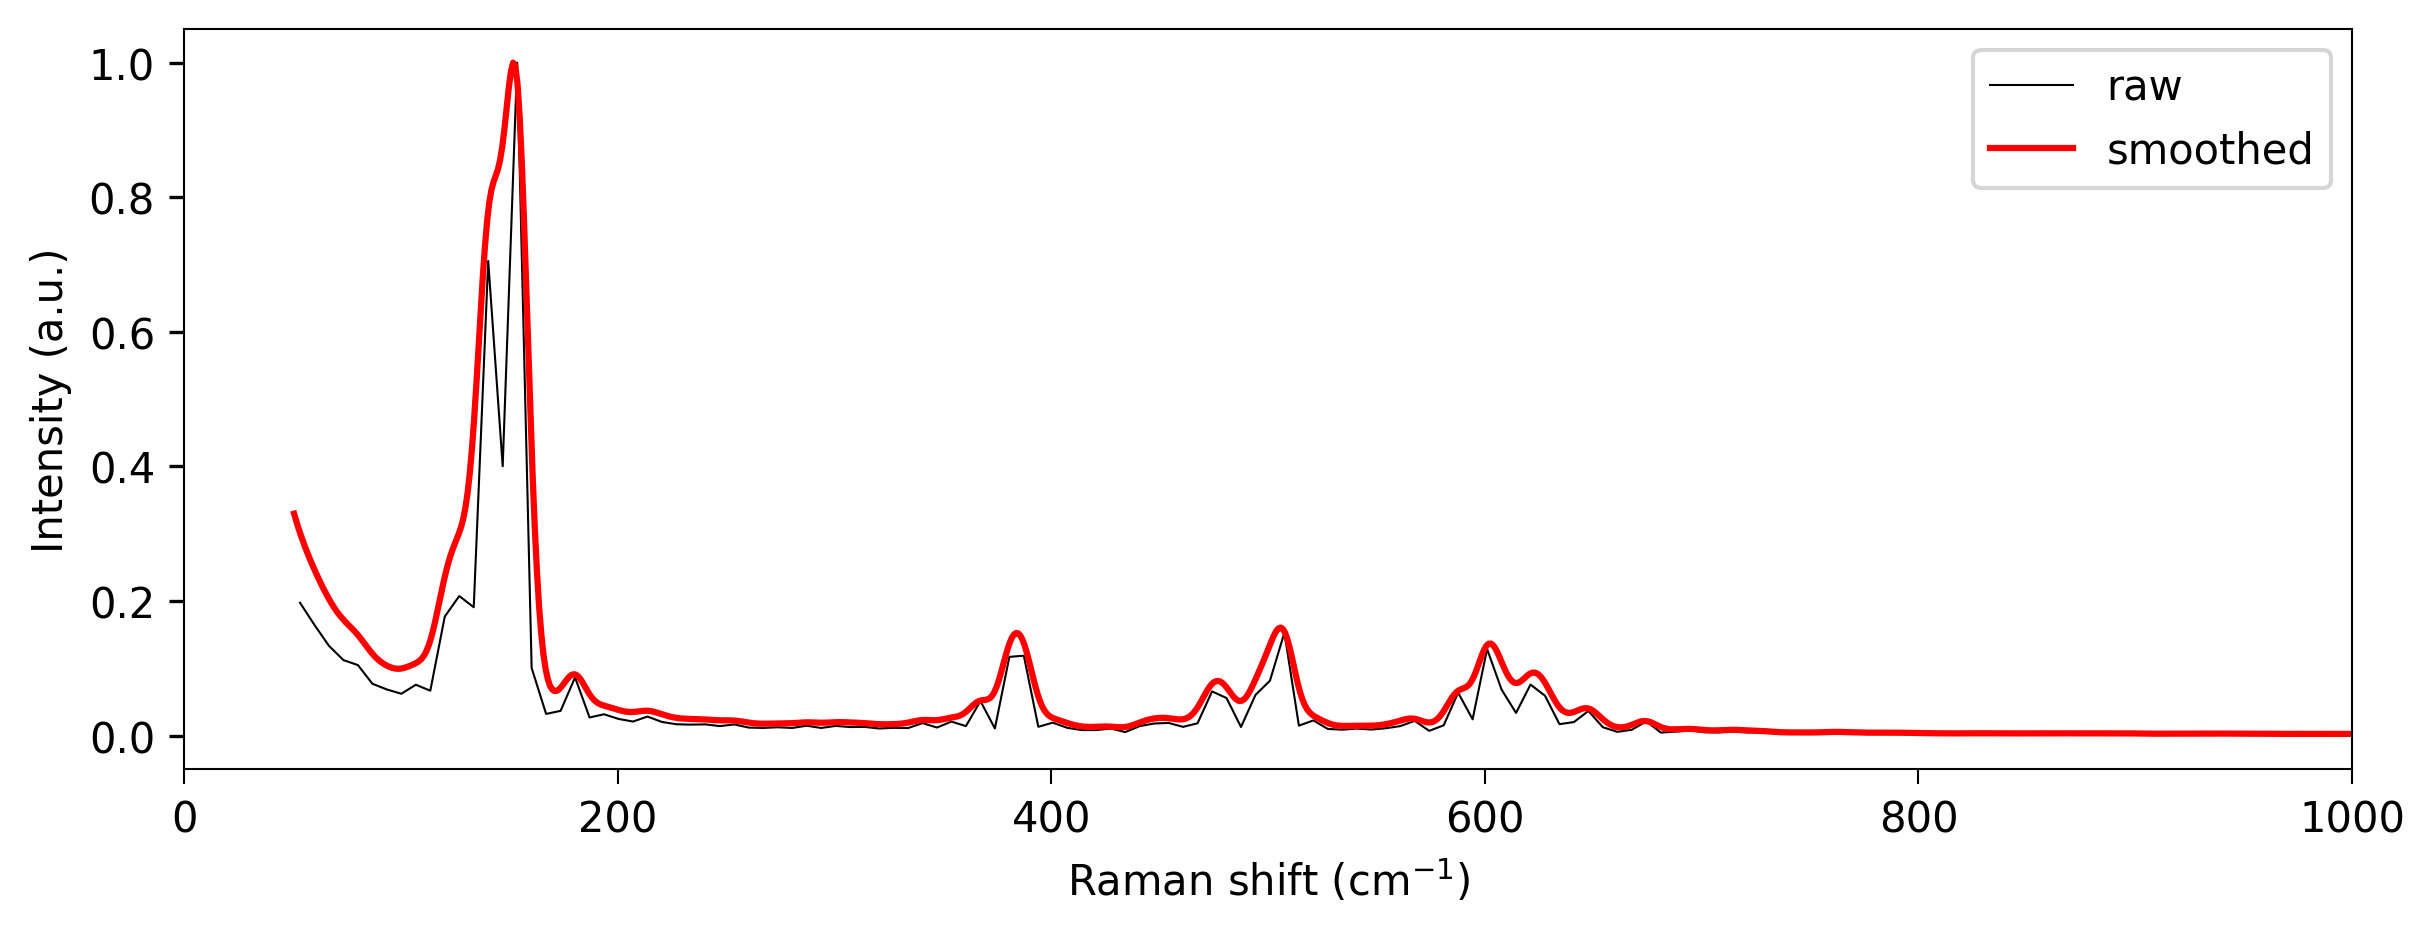

In [6]:
from ramannoodle.dynamics.trajectory import Trajectory


trajectory = vasp_io.xdatcar.read_trajectory(
    f"{data_dir}/MD_trajectory_XDATCAR", timestep = 5
)

# Compute spectrum
spectrum = trajectory.get_raman_spectrum(model)

# Then plot
wavenumbers, total_intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)

fig = plt.figure(constrained_layout = True, figsize = (8, 3))
axis = fig.add_subplot(111)
axis.plot(
    wavenumbers[wavenumbers > 50], 
    total_intensities[wavenumbers > 50] / np.max(total_intensities[wavenumbers > 50]), 
    label = "raw", color = 'black', linewidth = 0.5
)
wavenumbers, total_intensities = convolve_spectrum(wavenumbers, total_intensities)
axis.plot(
    wavenumbers[wavenumbers > 50], 
    total_intensities[wavenumbers > 50] / np.max(total_intensities[wavenumbers > 50]), 
    label = "smoothed", color = "red"
)
axis.set_xlim((0,1000))
axis.legend()
axis.set_ylabel("Intensity (a.u.)")
l = axis.set_xlabel(r"Raman shift ($\mathregular{cm^{-1}}$)")

The shorter length and larger timestep of this trajectory yields a lower quality Raman spectrum, though the key features are still present. 
